https://www-2.dc.uba.ar/materias/rn/tps/tp1-rn.pdf

In [578]:
import numpy as np
np.seterr(all='raise')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

### Funciones de costo

In [2]:
class error_cuadrático_medio:
    @staticmethod
    def f(predicción, objetivo):
        return np.mean(np.linalg.norm(predicción - objetivo, axis=1, ord=2)**2) * 0.5
    
    @staticmethod
    def d(predicción, objetivo):
        return predicción - objetivo
    

class error_absoluto_medio:
    @staticmethod
    def f(predicción, objetivo):
        return np.mean(np.linalg.norm(predicción - objetivo, axis=1, ord=1))
    
    @staticmethod
    def d(predicción, objetivo):
        return np.sign(predicción - objetivo)


class entropía_cruzada:
    @staticmethod
    def f(predicción, objetivo):
        return -np.mean( np.log(np.sum(objetivo * predicción, axis=1)) )
    
    @staticmethod
    def d(predicción, objetivo):
        return predicción - objetivo

### Funciones de activación

In [689]:
def escalón():
    f = lambda x: np.piecewise(x, [x < 0, x >= 0], [0, 1])
    d = lambda x: 1
    
    return f, d


def identidad():
    f = lambda x: x
    d = lambda x: 1
    
    return f, d


def relu():
    f = lambda x: np.maximum(0, x)
    d = lambda x: np.piecewise(x, [x <= 0, x > 0], [0, 1])

    return f, d


# leaky ReLU, la derivada para x <= 0 no es nula sino un valor pequeño
def lrelu():
    f = lambda x: np.maximum(0, x)
    d = lambda x: np.piecewise(x, [x <= 0, x > 0], [0.01, 1])

    return f, d


def logística():
    f = lambda x: 1 / (1 + np.exp(-x))
    d = lambda x: f(x) * (1 - f(x))

    return f, d


def tanh():
    f = np.tanh
    d = lambda x: 1 - f(x)**2
    
    return f, d


def softmax():
    def f(x):
        _x = x - np.max(x, axis=1, keepdims=True) # es para que no explote
        return np.exp(_x) / np.sum(np.exp(_x), axis=1, keepdims=True)
    
    def d(x):
        return 1.0 # implementada en la función de costo (entropía cruzada) por una cuestión de simplicidad
        
    return f, d

## Elementos de la red

Una **capa** se define en base a cierta cantidad de unidades con una función de activación.

En la **propagación** el parámetro `entrada` representa el valor de entrada a las unidades y el parámetro `salida`, el de salida. Cabe notar que a la salida se le agrega el bias de la capa. El bias es _virtual_, no está representado como unidad.

```
    entrada    función activación    salida
                                     | s0 | = 1 (BIAS)
    | e1 |                           | s1 |
    | e2 | --> f(entrada) ---------> | s2 |
    | e3 |                           | s3 |
```

Cuando consideramos la **retropropagación** del error, el sentido inverso utiliza los parámetros `error_entrada` y `error_salida` para los errores que *salen de y entran a* la capa, respectivamente.

```
    entrada     derivada activación  salida
                                     | es0 | = 1 (BIAS)
    | ee1 |                          | es1 |
    | ee2 | <- f'(entrada) ·         | es2 |
    | ee3 |          error_salida <- | es3 |
```

In [11]:
class Capa:
    
    def __init__(self, activación, unidades):
        self.función, self.derivada = activación()
        self.unidades = unidades
        self.feeds = []
        self.backs = []
        
        
    def propagar(self):
        Z = self.función(self.entrada)
        # (n_lote, dim_capa + 1) <- (n_lote, dim_capa)
        self.salida = np.insert(Z, 0, 1., axis=1) # agrega vector columna de bias

        for sinapsis in self.feeds: sinapsis.propagar()


    def retropropagar(self):
        # (n_lote, dim_capa) <- (n_lote, dim_capa + 1)
        E = np.delete(self.error_salida, 0, axis=1) # remueve vector columna de bias
        
        dZ = self.derivada(self.entrada)
        # (n_lote, dim_capa) <- (n_lote, dim_capa) * (n_lote, dim_capa) 
        self.error_entrada = E * dZ 
        
        for sinapsis in self.backs: sinapsis.retropropagar()
            
            
    def actualizar_pesos(self, eta, mu, _lambda):
        for sinapsis in self.feeds: sinapsis.actualizar_pesos(eta, mu, _lambda)
        
        
    def estado(self):
        return np.delete(self.salida, 0, axis=1) # remueve vector columna de bias
    
    
    def error(self, E):
        self.error_salida = np.insert(E, 0, 1., axis=1) # agregar vector columna de bias

Las capas se comunican mediante **sinapsis**. Una sinapsis tiene una capa de _origen_ y una de _destino_, a su vez guarda los pesos de las conexiones entre unidades.

Los elementos de la red están pensados para tratar a las muestas como *vectores filas*. En un arreglo bidimensional de varias muestras, cada fila es una muestra y las columnas del arreglo son los distintos atributos. En la bibliografía se suele observar otro camino: las muestras son *vectores columnas*; quizás sea más sencillo para hacer/interpretar cuentas. En la práctica, encontramos a los vectores filas más a tono con la forma de los conjuntos de datos (pensar en un archivo CSV o en una tabla de una base de datos).

```
    filas    = dim(origen) + 1 (BIAS)
    columnas = dim(destino)
    
    W =  | b00  b01 |  matriz de pesos de una sinapsis que conecta una capa de 3 unidades (origen) con otra de 2 (destino)
         | w10  w11 |  la primera fila corresponde a los pesos del bias
         | w20  w21 |
         | w30  w31 |
         
    Y =  | 1  a1  a2  a3 |  actividad de salida de la capa de origen, 2 muestras con 3 atributos y bias (primera columna)
         | 1  b1  b2  b3 |
         
    Z =  Y · W =  | a'1  a'2 |  la actividad de entrada a la capa de destino entonces se calcula
                  | b'1  b'2 |  como el producto interno entre la salida (Y) y los pesos (W)
```

In [156]:
class Sinapsis:
  
    def __init__(self, origen, destino):
        # capas
        self.origen  = origen
        self.destino = destino
        
        self.forma   = (origen.unidades + 1, destino.unidades)
        
        self.V_prev      = np.zeros(self.forma)
        self.V           = np.zeros(self.forma)
        self.delta_pesos = np.zeros(self.forma)
        # inicialización He et al.
        # http://cs231n.github.io/neural-networks-2/#init
        self.pesos       = np.random.standard_normal(size=self.forma) * np.sqrt(2.0/self.forma[0])
        
        
    def propagar(self):
        # (n_lote, dim_destino) <- (n_lote, dim_origen + 1) . (dim_origen + 1, dim_destino)
        self.destino.entrada = np.dot(self.origen.salida, self.pesos)
    
    
    def retropropagar(self):
        # (n_lote, dim_origen + 1) <- (n_lote, dim_destino) . (dim_destino, dim_origen + 1) 
        self.origen.error_salida = np.dot(self.destino.error_entrada, self.pesos.T)
        
        n_lote = self.destino.error_entrada.shape[0]
        # (dim_origen + 1, dim_destino) <- (dim_origen + 1, n_lote) . (n_lote, dim_destino)
        self.delta_pesos = np.dot(self.origen.salida.T, self.destino.error_entrada) / n_lote # promedio de las contribuciones
                                                                                             # de cada muestra
                
    def actualizar_pesos(self, eta, mu, _lambda):
        """http://cs231n.github.io/neural-networks-3/
        
        Momento
        v = mu * v - learning_rate * dx    # integrate velocity
        x += v                             # integrate position

        Momento de Nesterov
        v_prev = v                         # back this up
        v = mu * v - learning_rate * dx    # velocity update stays the same
        x += -mu * v_prev + (1 + mu) * v   # position update changes form

        Recommended annealing schedules for mu: 0.5, 0.9, 0.95, 0.99
        """
        
        self.V_prev =  self.V
        self.V      =  mu * self.V - eta * (self.delta_pesos + _lambda * self.pesos)
        self.pesos += -mu * self.V_prev + (1 + mu) * self.V

El **perceptrón**.

In [590]:
from sklearn.base import BaseEstimator

class Red(BaseEstimator):

    def __init__(self, activación=logística, capas_ocultas=(), última_capa=None, costo=error_cuadrático_medio,
                 épocas=100, tolerancia=1e-3, lote=1, 
                 aprendizaje=1e-3, momento=0, adaptación=0, regularización=0,
                 validación=False, graficar=False):
        
        # estructura de la red
        self.activación    = activación
        self.capas_ocultas = capas_ocultas
        self.última_capa   = última_capa or activación
        self.costo         = costo
        
        # hiperparámetros aprendizaje A
        self.épocas     = épocas
        self.tolerancia = tolerancia
        self.lote       = lote
        
        # hiperparámetros aprendizaje B
        self.aprendizaje    = aprendizaje
        self.momento        = momento
        self.adaptación     = adaptación
        self.regularización = regularización
        
        # otros
        self.validación = validación
        self.graficar = graficar
        
        # el chequeo sirve para verificar el buen funcionamiento de la optimización
        self.chequeo = False
        self.épsilon = 1e-4
        
        
    @staticmethod
    def lotes(X, y, n):
        if n < 1: n = len(X)

        for i in range(0, len(X), n):
            yield X[i:i+n], y[i:i+n]


    @staticmethod
    def barajar(X, y):
        e = np.random.get_state()
        X = np.random.permutation(X)
        np.random.set_state(e)
        y = np.random.permutation(y)

        return X, y


    @staticmethod
    def graficar(evolución_error, c='b'):
        p, = plt.plot(evolución_error, c=c)
        plt.yscale('log')
        plt.xlabel('épocas')
        plt.ylabel('error')
        return p


    def _inicializar(self, n_entradas, n_salidas):
        self.capas    = OrderedDict()
        self.sinapsis = OrderedDict()
        
        # instanciación de capas
        self.capas['entrada'] = Capa(identidad, n_entradas)
        
        for i, n_unidades in enumerate(self.capas_ocultas):
            id_capa = 'oculta_%s' % (i + 1)
            self.capas[id_capa] = Capa(self.activación, n_unidades)
        
        self.capas['salida'] = Capa(self.última_capa, n_salidas)
        
        # se asume que la red es feed-forward
        ids_capas  = list(self.capas.keys())
        conexiones = [(capa_origen, capa_destino) for capa_origen, capa_destino in zip(ids_capas, ids_capas[1:])]
            
        # instanciación de sinapsis
        for (id_origen, id_destino) in conexiones:
            origen   = self.capas[id_origen]
            destino  = self.capas[id_destino]
            
            sinapsis = self.sinapsis[(id_origen, id_destino)] = Sinapsis(origen, destino)
            
            origen.feeds.append(sinapsis)
            destino.backs.append(sinapsis)        
    

    def fit(self, X, y):
        # asegurarse de que 'y' sea 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))
            
        tamaño_lote = self.lote or X.shape[0]
        
        n_entradas = X.shape[1]
        n_salidas  = y.shape[1]
        
        self._inicializar(n_entradas, n_salidas)
        
        self.evolución_error = []
        self.evolución_validación = []
        self.convergencia = False
        
        if self.validación:
            X_val, y_val = self.validación
            
            if y_val.ndim == 1:
                y_val = y_val.reshape((-1, 1))

        if self.graficar:
            %matplotlib notebook
            fig = plt.figure()
            ax  = fig.gca()
        
            ax.set_yscale('log')
            ax.set_xlabel('épocas')
            ax.set_ylabel('error')
            plt.ion()

                        
        for época in range(self.épocas):            
            eta = self.aprendizaje * np.exp(-self.adaptación * época) 
            
            _X, _y = self.barajar(X, y)
            
            for lote_X, lote_y in self.lotes(_X, _y, self.lote):
                self._aprender(lote_X, lote_y, eta, self.momento, self.regularización)
            
            error = self.costo.f(_y, self.predict(_X))
            self.evolución_error.append(error)
            
            if self.validación:
                error_validación = self.costo.f(y_val, self.predict(X_val))
                self.evolución_validación.append(error_validación)
                
            if self.graficar:
                e = ax.plot(self.evolución_error, c='b', label='entrenamiento')
                
                if self.validación:
                    v = ax.plot(self.evolución_validación, c='g', label='validación')
    
                ax.set_xlim([época - 10, época])
                #ax.set_ylim([1e-6, 10])
            
                ax.set_title('n = {:.2e} | µ = {:.2f}'.format(eta, self.momento))
                fig.canvas.draw()
                
            if error <= self.tolerancia:
                self.convergencia = época
                break
        
        return self
       
                 
    def _aprender(self, X, y_objetivo, eta, mu, _lambda):
        self.capas['salida'].error(self.costo.d(self.predict(X), y_objetivo)) 
        
        for _, capa in reversed(self.capas.items()): capa.retropropagar()
        
        if self.chequeo: self._chequeo(X, y_objetivo)
        
        for _, capa in self.capas.items(): capa.actualizar_pesos(eta, mu, _lambda)

        
    def _chequeo(self, X, y_objetivo):
        índice_sinapsis = np.random.randint( len(self.sinapsis.values()) )
        sinapsis = list(self.sinapsis.values())[índice_sinapsis]
            
        unidad_origen  = np.random.randint(sinapsis.forma[0]) # filas
        unidad_destino = np.random.randint(sinapsis.forma[1]) # columnas
            
        peso_original  = sinapsis.pesos[unidad_origen][unidad_destino]
        
        sinapsis.pesos[unidad_origen][unidad_destino] = peso_original + self.épsilon
        error_más      = self.costo.f(self.predict(X), y_objetivo)
            
        sinapsis.pesos[unidad_origen][unidad_destino] = peso_original - self.épsilon
        error_menos    = self.costo.f(self.predict(X), y_objetivo)

        sinapsis.pesos[unidad_origen][unidad_destino] = peso_original
            
        g  = (error_más - error_menos) / (2 * self.épsilon)
        dw = sinapsis.delta_pesos[unidad_origen][unidad_destino]
        print(dw, '\t', g)
        
    
    def predict(self, X):
        self.capas['entrada'].entrada = X
        
        for _, capa in self.capas.items(): capa.propagar()
        
        return self.capas['salida'].estado()

In [455]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import binarize
from sklearn.preprocessing   import LabelBinarizer

class Clasificador(Red):
        
    def score(self, X, y):
        #return accuracy_score(y, binarize(self.predict(X), threshold=0.5))
        #return f1_score(y, binarize(self.predict(X), threshold=0.5))
        y_pred = self.label_binarizer.inverse_transform(self.predict(X))
        return accuracy_score(y_pred, y)

    
class Regresor(Red):
   
    def score(self, X, y):
        return -error_cuadrático_medio.f(self.predict(X), y)

## Experimentos

In [189]:
import pandas as pd

columnas = [
    'diagnóstico',
    'radio',
    'textura',
    'perímetro',
    'área',
    'suavidad',
    'compacidad',
    'concavidad',
    'puntos_cóncavos',
    'simetría',
    'densidad'
]

ej1 = pd.read_csv('tp1_ej1_training.csv', header=None, names=columnas)

In [190]:
ej1.dtypes

diagnóstico         object
radio              float64
textura            float64
perímetro          float64
área               float64
suavidad           float64
compacidad         float64
concavidad         float64
puntos_cóncavos    float64
simetría           float64
densidad           float64
dtype: object

In [191]:
ej1.diagnóstico.value_counts()

B    215
M    195
Name: diagnóstico, dtype: int64

La respuesta, **diagnóstico**, es del tipo categórica y debe ser binarizada. Las muestras de cada clase son similares en cantidad, no hace falta tomar acciones para balancear el conjunto de datos. El resto de las variables deben ser estandarizadas.

In [192]:
from sklearn.preprocessing import label_binarize

ej1.diagnóstico = label_binarize(ej1.diagnóstico, classes=['B', 'M'])

In [193]:
ej1.head()

,diagnóstico,radio,textura,perímetro,área,suavidad,compacidad,concavidad,puntos_cóncavos,simetría,densidad
0,1,11.779,29.321,93.649,1300.312,2.469,1.071,4.459,6.299,0.586,1.506
1,0,18.631,16.772,126.232,657.973,1.659,1.230,4.179,5.549,0.678,1.734
2,0,11.221,29.886,120.610,1302.758,2.519,2.485,5.281,6.633,0.748,1.999
3,1,14.418,29.200,101.041,1384.419,2.519,1.545,3.802,4.359,0.527,1.778
4,0,20.089,27.558,99.301,917.233,2.107,1.986,2.447,1.845,0.693,1.499


In [197]:
from sklearn.model_selection import train_test_split

ej1_train, ej1_val = train_test_split(ej1, test_size=.2, random_state=42)

In [179]:
from sklearn_pandas import DataFrameMapper

from sklearn.preprocessing import StandardScaler

mapper = DataFrameMapper([
    (['radio', 'textura', 'perímetro',
      'área', 'suavidad', 'compacidad',
      'concavidad', 'puntos_cóncavos',
      'simetría', 'densidad'], StandardScaler())
])

#### Estimador de referencia

Es un ensamble de árboles de decisión. Los mismos no requieren que los atributos estén estandarizados.

In [281]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth=5, n_estimators=300, random_state=42)

clf.fit(ej1_train.drop('diagnóstico', axis=1), ej1_train.diagnóstico)

'Efectividad (validación): %.2f' % clf.score(ej1_val.drop('diagnóstico', axis=1), ej1_val.diagnóstico)

'Efectividad (validación): 0.85'

#### Red neuronal

In [295]:
X_train = mapper.fit_transform(ej1_train)
y_train = ej1_train['diagnóstico']

X_val = mapper.transform(ej1_val)
y_val = ej1_val['diagnóstico']

In [585]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import binarize

def experimento(figura=False, **args):
    r = Red(validación=(X_val, y_val), **args).fit(X_train, y_train)
    
    y_pred = binarize(r.predict(X_val), threshold=0.5)
    puntaje = accuracy_score(y_val, y_pred)
         
    if figura:
        %matplotlib inline

        fig, ax = plt.subplots(figsize=(4,3))

        v = ax.plot(r.evolución_validación, c='g', label='validación')
        e = ax.plot(r.evolución_error, c='b', label='entrenamiento')

        ax.legend()
        ax.set_yscale('log')
        ax.set_xlabel('épocas')
        ax.set_ylabel('error')

        capas = ':'.join([str(capa.unidades) for _, capa in r.capas.items()])
        ax.set_title('{} - {}'.format(r.activación.__name__, capas))
    
        plt.savefig('ej1:{:.2f}_activ:{}_capas:{}_ultim:{}_costo:{}_apren:{:.1e}_momen:{:.1e}_adapt:{:.1e}_regul:{:.1e}_lote:{}_epocas:{}_conver:{}.png' \
                .format(puntaje, r.activación.__name__, capas, r.última_capa.__name__, r.costo.__name__, \
                        r.aprendizaje, r.momento, r.adaptación, r.regularización, r.lote, r.épocas, r.convergencia))
    
    return 'Efectividad (validación): %.2f' % puntaje

#### Misma tasa de aprendizaje, distintas cantidad de unidades de la capa oculta

'Efectividad (validación): 0.82'

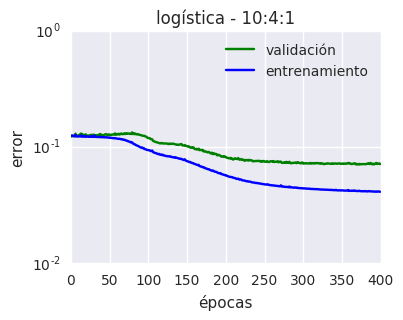

In [639]:
experimento(
    figura=True,
    épocas=400,
    capas_ocultas=(4,),
    aprendizaje=1e-1,
    activación=logística,
    lote=1
)

'Efectividad (validación): 0.88'

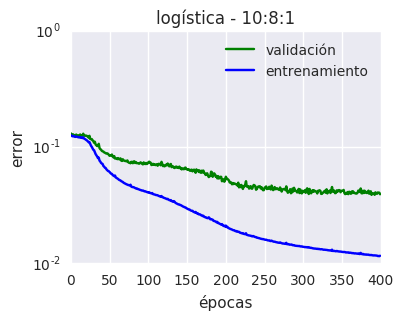

In [638]:
experimento(
    figura=True,
    épocas=400,
    capas_ocultas=(8,),
    aprendizaje=1e-1,
    activación=logística,
    lote=1
)

'Efectividad (validación): 0.88'

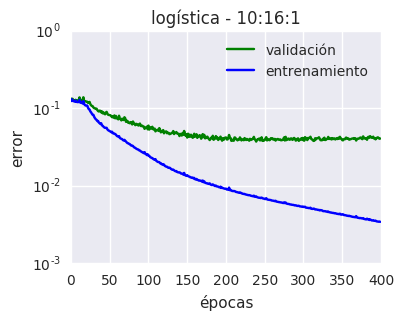

In [637]:
experimento(
    figura=True,
    épocas=400,
    capas_ocultas=(16,),
    aprendizaje=1e-1,
    activación=logística,
    lote=1
)

'Efectividad (validación): 0.87'

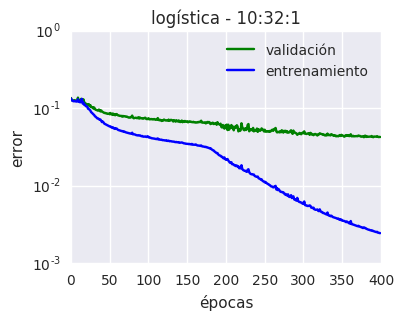

In [636]:
experimento(
    figura=True,
    épocas=400,
    capas_ocultas=(32,),
    aprendizaje=1e-1,
    activación=logística,
    lote=1
)

'Efectividad (validación): 0.85'

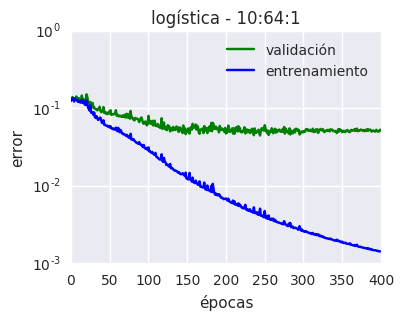

In [635]:
experimento(
    figura=True,
    épocas=400,
    capas_ocultas=(64,),
    aprendizaje=1e-1,
    activación=logística,
    lote=1
)

'Efectividad (validación): 0.87'

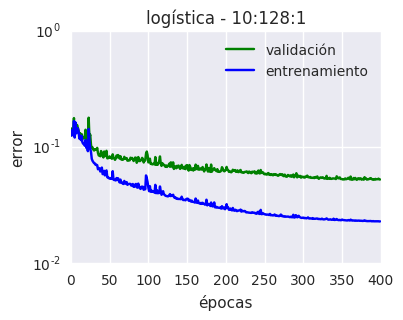

In [634]:
experimento(
    figura=True,
    épocas=400,
    capas_ocultas=(128,),
    aprendizaje=1e-1,
    activación=logística,
    lote=1
)

'Efectividad (validación): 0.79'

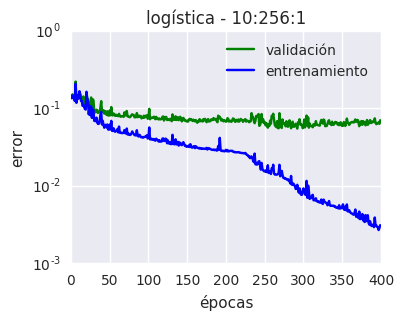

In [633]:
experimento(
    figura=True,
    épocas=400,
    capas_ocultas=(256,),
    aprendizaje=1e-1,
    activación=logística,
    lote=1
)

#### Misma cantidad de unidades, distintas tasas de aprendizaje

'Efectividad (validación): 0.74'

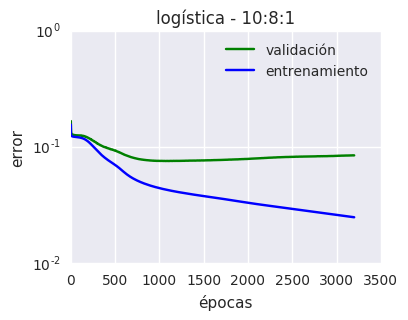

In [661]:
experimento(
    figura=True,
    épocas=3200,
    capas_ocultas=(8,),
    aprendizaje=1e-2,
    activación=logística,
    lote=1
)

'Efectividad (validación): 0.87'

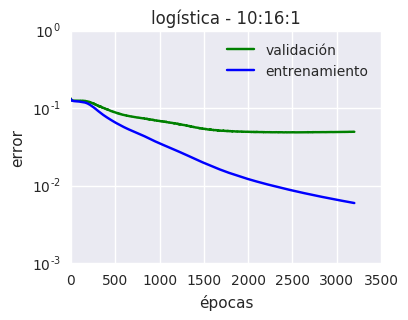

In [662]:
experimento(
    figura=True,
    épocas=3200,
    capas_ocultas=(16,),
    aprendizaje=1e-2,
    activación=logística,
    lote=1
)

'Efectividad (validación): 0.84'

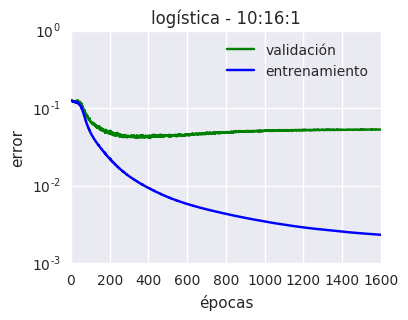

In [658]:
experimento(
    figura=True,
    épocas=1600,
    capas_ocultas=(16,),
    aprendizaje=5e-2,
    activación=logística,
    lote=1
)

'Efectividad (validación): 0.49'

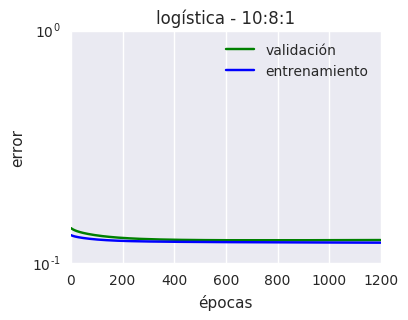

In [656]:
experimento(
    figura=True,
    épocas=1200,
    capas_ocultas=(8,),
    aprendizaje=1e-3,
    activación=logística,
    lote=1
)

'Efectividad (validación): 0.52'

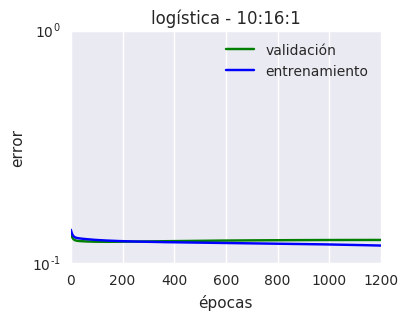

In [657]:
experimento(
    figura=True,
    épocas=1200,
    capas_ocultas=(16,),
    aprendizaje=1e-3,
    activación=logística,
    lote=1
)

#### Regularización

'Efectividad (validación): 0.83'

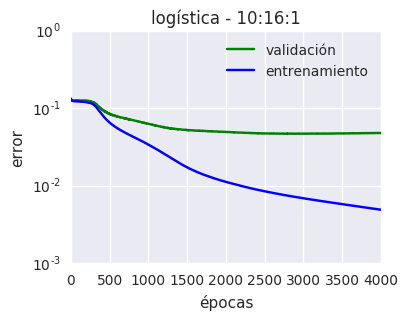

In [667]:
experimento(
    figura=True,
    épocas=4000,
    capas_ocultas=(16,),
    aprendizaje=1e-2,
    regularización=1e-5,
    activación=logística,
    lote=1
)

'Efectividad (validación): 0.88'

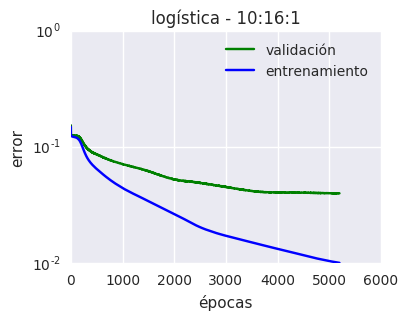

In [669]:
experimento(
    figura=True,
    épocas=5200,
    capas_ocultas=(16,),
    aprendizaje=1e-2,
    regularización=1e-4,
    activación=logística,
    lote=1
)

#### Adaptación

La tasa de aprendizaje $\eta$ se adapta de manera decayente, según una tasa inicial $\eta_0$ por una exponencial decreciente.

$\eta = \eta_0 e^{-\alpha t}$.

$t$ es la época y $\alpha$ un parámetro que reduce la tasa en un 63% cada $1/\alpha$ épocas.

'Efectividad (validación): 0.90'

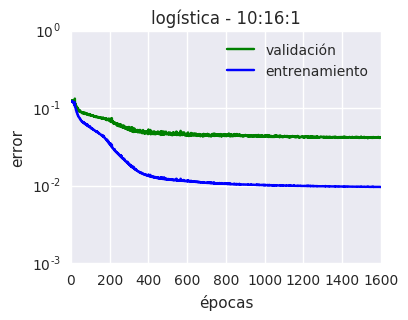

In [675]:
experimento(
    figura=True,
    épocas=1600,
    capas_ocultas=(16,),
    aprendizaje=1e-1,
    adaptación=1/1600,
    regularización=1e-4,
    activación=logística,
    lote=1
)

### Ejercicio 2

In [680]:
import pandas as pd

columnas = [
    'compacidad_relativa',
    'área_superficie_total',
    'área_paredes',
    'área_techo',
    'altura_total',
    'orientación',
    'área_reflejo_total',
    'distribución_área_reflejo',
    'carga_calefacción',
    'carga_refrigeración'
]

ej2 = pd.read_csv('tp1_ej2_training.csv', header=None, names=columnas)

In [56]:
ej2.dtypes

compacidad_relativa          float64
área_superficie_total        float64
área_paredes                 float64
área_techo                   float64
altura_total                 float64
orientación                    int64
área_reflejo_total           float64
distribución_área_reflejo      int64
carga_calefacción            float64
carga_refrigeración          float64
dtype: object

Las variables **orientación** y **distribución del área de reflejo** son categóricas. Tendrán que ser codificadas. El resto de las variables independientes serán estandarizadas.

In [681]:
objetivos = ['carga_calefacción', 'carga_refrigeración']

ej2[objetivos].agg(['mean', 'std'])

,carga_calefacción,carga_refrigeración
mean,22.163800,24.471620
std,10.113103,9.599674


Las variables objetivo **carga de calefacción** y **carga de refrigeración** tienen media y desviación estándar similares. El caso contrario requeriría preprocesar las variables para que ninguna unidad de salida de la red neuronal domine sobre la otra.

In [196]:
ej2.head()

,compacidad_relativa,área_superficie_total,área_paredes,área_techo,altura_total,orientación,área_reflejo_total,distribución_área_reflejo,carga_calefacción,carga_refrigeración
0,0.71,710.5,269.5,220.5,3.5,5,0.10,1,10.75,14.27
1,0.79,637.0,343.0,147.0,7.0,5,0.25,2,38.98,45.97
2,0.66,759.5,318.5,220.5,3.5,3,0.10,1,11.69,13.72
3,0.62,808.5,367.5,220.5,3.5,2,0.40,5,16.54,16.88
4,0.76,661.5,416.5,122.5,7.0,2,0.00,0,24.77,29.79


In [682]:
from sklearn.model_selection import train_test_split

ej2_train, ej2_val = train_test_split(ej2, test_size=.2, random_state=42)

In [683]:
from sklearn_pandas import DataFrameMapper

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

mapper = DataFrameMapper([
    (['compacidad_relativa', 'área_superficie_total', 'área_paredes',
      'área_techo', 'altura_total', 'área_reflejo_total'], StandardScaler()), 
    (['orientación', 'distribución_área_reflejo'], OneHotEncoder())
])

#### Métrica

Se eligió el [coeficiente R²](https://en.wikipedia.org/wiki/Coefficient_of_determination) como métrica adicional al costo (*error absoluto medio*) para evaluar el desempeño de los estimadores.

In [684]:
from sklearn.metrics import r2_score

#### Estimador de referencia

In [135]:
from sklearn.linear_model import Ridge

r = Ridge(alpha=.001)


from sklearn.pipeline import make_pipeline

e = make_pipeline(mapper, reg)
e.fit(ej2_train, ej2_train[objetivos])

print('Coeficiente R^2 (validación): %.2f' % e.score(ej2_val, ej2_val[objetivos]))
print('Error absoluto medio (validación): %.2f' % error_absoluto_medio.f(e.predict(ej2_val), ej2_val[objetivos]))

Coeficiente R^2 (validación): 0.91
Error absoluto medio (validación): 3.98


#### Red neuronal

Algunos problemas de underflow.

In [164]:
np.geterr()
#np.seterr(under='ignore')

{'divide': 'raise', 'invalid': 'ignore', 'over': 'raise', 'under': 'raise'}

In [685]:
X_train = mapper.fit_transform(ej2_train)
Y_train = ej2_train[objetivos]

X_val = mapper.transform(ej2_val)
Y_val = ej2_val[objetivos]

In [766]:
def experimento_2(**args):
    r = Red(validación=(X_val, Y_val), **args).fit(X_train, Y_train)
    puntaje = r2_score(r.predict(X_val), Y_val)
    print('Coeficiente R^2 (validación): %.2f' % puntaje)

    %matplotlib inline
    fig, ax = plt.subplots(figsize=(4,3))

    v = ax.plot(r.evolución_validación, c='g', label='validación')
    e = ax.plot(r.evolución_error, c='b', label='entrenamiento')

    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel('épocas')
    ax.set_ylabel('error')

    capas = ':'.join([str(capa.unidades) for _, capa in r.capas.items()])
    ax.set_title('{} - {}'.format(r.activación.__name__, capas))

    plt.savefig('ej2:{:.2f}_activ:{}_capas:{}_apren:{:.1e}_momen:{:.1e}_adapt:{:.1e}_regul:{:.1e}_lote:{}_epocas:{}.png' \
            .format(puntaje, r.activación.__name__, capas, r.aprendizaje, r.momento, r.adaptación, r.regularización, r.lote, r.épocas))
    
    return r

Coeficiente R^2 (validación): 0.88


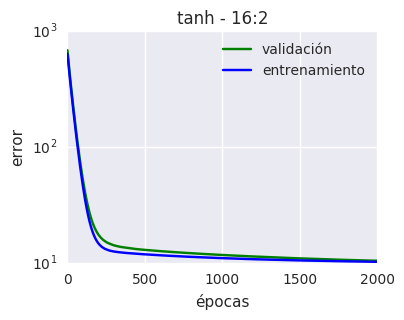

In [767]:
r = experimento_2(
    épocas=2000,
    capas_ocultas=(),
    adaptación=0,
    aprendizaje=1e-5,
    regularización=1e-4,
    momento=.9,
    activación=tanh,
    última_capa=identidad,
    lote=4
)

Coeficiente R^2 (validación): 0.90


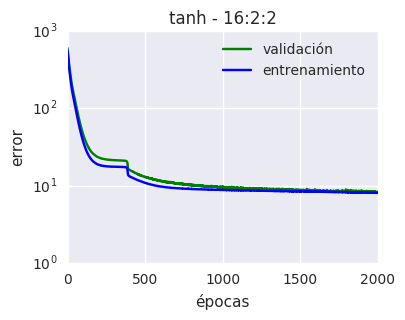

In [768]:
r = experimento_2(
    épocas=2000,
    capas_ocultas=(2,),
    adaptación=0,
    aprendizaje=1e-5,
    regularización=1e-4,
    momento=.9,
    activación=tanh,
    última_capa=identidad,
    lote=4
)

Coeficiente R^2 (validación): 0.95


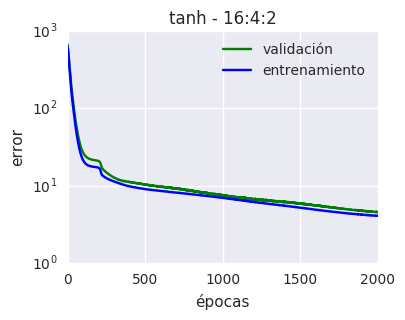

In [769]:
r = experimento_2(
    épocas=2000,
    capas_ocultas=(4,),
    adaptación=0,
    aprendizaje=1e-5,
    regularización=1e-4,
    momento=.9,
    activación=tanh,
    última_capa=identidad,
    lote=4
)

Coeficiente R^2 (validación): 0.97


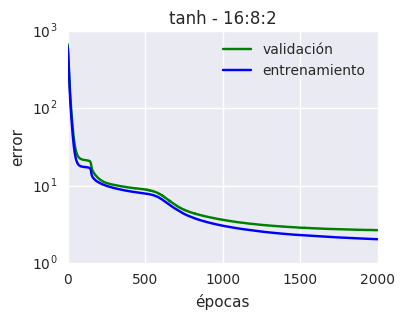

In [770]:
r = experimento_2(
    épocas=2000,
    capas_ocultas=(8,),
    adaptación=0,
    aprendizaje=1e-5,
    regularización=1e-4,
    momento=.9,
    activación=tanh,
    última_capa=identidad,
    lote=4
)

Coeficiente R^2 (validación): 0.98


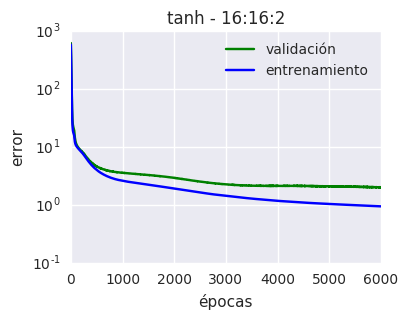

In [773]:
r = experimento_2(
    épocas=6000,
    capas_ocultas=(16,),
    adaptación=0,
    aprendizaje=1e-5,
    regularización=1e-4,
    momento=.9,
    activación=tanh,
    última_capa=identidad,
    lote=4
)

Coeficiente R^2 (validación): 0.99


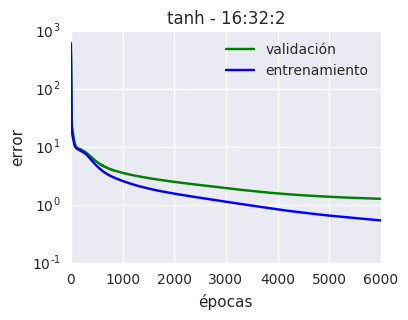

In [774]:
r = experimento_2(
    épocas=6000,
    capas_ocultas=(32,),
    adaptación=0,
    aprendizaje=1e-5,
    regularización=1e-4,
    momento=.9,
    activación=tanh,
    última_capa=identidad,
    lote=4
)

In [775]:
17*16+17*2

306

In [776]:
17*4+5*4+5*2

98

Coeficiente R^2 (validación): 0.98


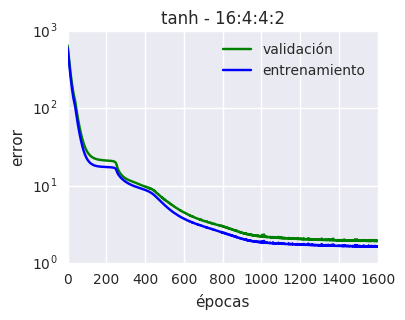

In [765]:
r = experimento_2(
    épocas=1600,
    capas_ocultas=(4,4),
    adaptación=0,
    aprendizaje=1e-5,
    regularización=1e-4,
    momento=.9,
    activación=tanh,
    última_capa=identidad,
    lote=4
)

La complejidad del modelo está dada en parte por la cantidad de parámetros a ajustar. En el caso de las redes feed-forward la cuenta es ... . Utilizando la "navaja de Occam" dice que el mejor modelo entre los que funcionan bien, es el más simple posible. Quiere decir que es preferible quedarnos con las redes de menor cantidad de parámetros posibles, ya

In [ ]:
r = experimento_2(
    épocas=1600,
    capas_ocultas=(8,8),
    adaptación=0,
    aprendizaje=1e-5,
    regularización=1e-4,
    momento=.9,
    activación=tanh,
    última_capa=identidad,
    lote=4
)

Coeficiente R^2 (validación): 0.97


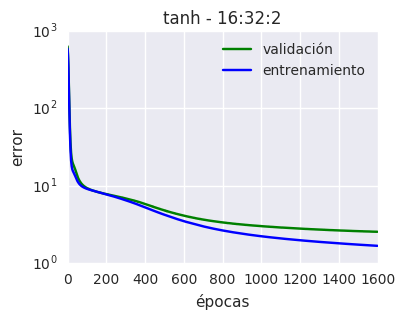

In [752]:
r = experimento_2(
    épocas=1600,
    capas_ocultas=(32,),
    adaptación=0,
    aprendizaje=1e-5,
    regularización=1e-4,
    momento=.9,
    activación=tanh,
    última_capa=identidad,
    lote=4
)

Coeficiente R^2 (validación): 0.97


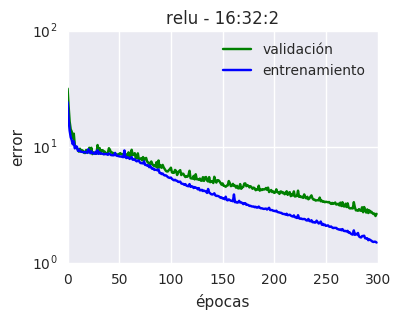

In [734]:
r = experimento_2(
    épocas=300,
    capas_ocultas=(32,),
    adaptación=0,
    aprendizaje=5e-5,
    regularización = .0001,
    momento=.9,
    activación=relu,
    última_capa=identidad,
    lote=2
)

In [727]:
predicciones = r.predict(X_val)

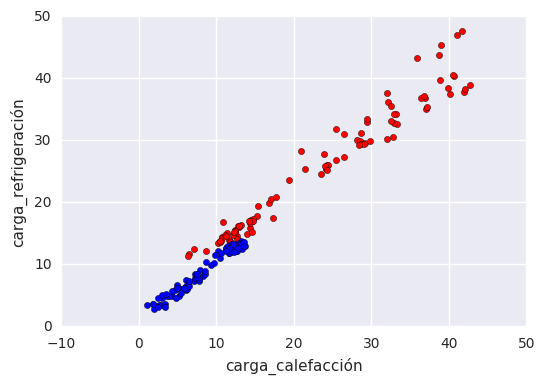

In [728]:
fig, ax = plt.subplots()
Y_val.plot.scatter('carga_calefacción', 'carga_refrigeración', ax=ax, c='red')
ax.scatter(predicciones[:,0], predicciones[:,1])

* función de activación - costo
  * ej1 logística - error cuadrático medio
  * ej2 tanh/identidad - error cuadrático medio
  * ej3 relu - softmax
* capas

* épocas
* tolerancia
* lote: estocástico/batch/mini-batch

* tasa de aprendizaje
* factor momento
* adaptación
* regularización

estocástico + fit agresivo (eta, mu ~ 1) suele explotar

muchas unidades implica cuidar la inicialización de los pesos porque explotan

como los resultados van entre 0 y 1 se escogió logística y relu. relu no da buenos resultados. 

* función de activación softmax en la última capa
* derivada de softmax

* función de pérdida (cross entropy)
* derivada de la función de pérdida para el error

### MNIST

In [36]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

mnist = fetch_mldata('MNIST original')
X, y = mnist.data / 255., mnist.target
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

<IPython.core.display.Javascript object>


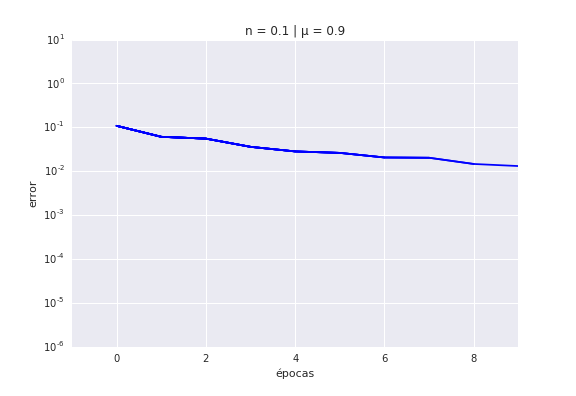

0.98050000000000004

In [44]:
r = Clasificador(épocas=10, lote=128, capas_ocultas=(256,), activación=relu, costo=entropía_cruzada,
                 aprendizaje=.1, momento=.9, regularización=.0001, graficar=True)

r.fit(X_train, y_train)
r.score(X_test, y_test)